In [1]:
import sys
import os
from pathlib import Path

src_path = Path.home() / "QuditEM" / "src"

src_path = src_path.resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [2]:
from qudit_ops.operators import *
from qudit_ops.pcs import get_counts,plot_histogram,postselection
from qudit_ops.pcs import hellinger_fidelity
import math
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

# PCS in ququart space

## Test A: Detecting all X and Z errors in qutrit space (Success)

In [32]:
qudits0 = cirq.LineQid.range(3, dimension=3)
moment = cirq.Moment(Christensen(3).on_each(*qudits0[1:]))
circuit_a = cirq.Circuit(
    moment,
    CZGate(1,1,3).on(qudits0[2],qudits0[0]),CZGate(2,2,3).on(qudits0[2],qudits0[0]),
    CModAdd(2,1,3).on(*qudits0[-2::-1]),CModAdd(1,2,3).on(*qudits0[-2::-1]), 
    ModAdd(1,3).on(qudits0[0]),
    ZGate(1,3).on(qudits0[0]),
    #QuditDepolarizingChannel(0.12,3)(qudits0[0]),
    CModAdd(1,1,3).on(*qudits0[-2::-1]), CModAdd(2,2,3).on(*qudits0[-2::-1]),
    CZGate(1,2,3).on(qudits0[2],qudits0[0]),CZGate(2,1,3).on(qudits0[2],qudits0[0]),
    moment,cirq.measure(*qudits0,key="a")
)
print(circuit_a)

0 (d=3): ────────Z─────Z2────[+]───[++]───[+]───Z───[+]───[++]───Z2────Z──────────M('a')───
                 │     │     │     │                │     │      │     │          │
1 (d=3): ───Cr───┼─────┼─────(2)───(1)──────────────(1)───(2)────┼─────┼─────Cr───M────────
                 │     │                                         │     │          │
2 (d=3): ───Cr───(1)───(2)───────────────────────────────────────(1)───(2)───Cr───M────────


In [33]:
sim = cirq.Simulator()
print(sim.run(circuit_a,repetitions=50))

a=11111111111111111111111111111111111111111111111111, 11111111111111111111111111111111111111111111111111, 11111111111111111111111111111111111111111111111111


## Test B: Detecting all X and Z errors in ququart space EDIT: Success

In [29]:
qudits1 = cirq.LineQid.range(4,dimension=4)
c_moment = cirq.Moment(Christensen(4).on_each(qudits1[1],qudits1[2]))
# left_check = cirq.Moment()
# right_check = cirq.Moment(cirq.Moment(CZGate(1,1,4).on(qudits1[0]),CZGate(2,2,4).on(qudits1[0]),CZGate(3,3,4).on(qudits1[0])))
error_moment = (cirq.Moment(QuditDepolarizingChannel(0.3,4)(qudits1[0])))
circuit_b = cirq.Circuit(
    c_moment, 
    
    CZGate(1,1,4).on(qudits1[2],qudits1[0]),CZGate(2,2,4).on(qudits1[2],qudits1[0]),CZGate(3,3,4).on(qudits1[2],qudits1[0]), 
    CModAdd(1,3,4).on(qudits1[1],qudits1[0]),CModAdd(2,2,4).on(qudits1[1],qudits1[0]),CModAdd(3,1,4).on(qudits1[1],qudits1[0]),
    ZGate(1,4).on(qudits1[0]), ModAdd(3,4).on(qudits1[0]),
    CModAdd(1,1,4).on(qudits1[1],qudits1[0]), CModAdd(2,2,4).on(qudits1[1],qudits1[0]),CModAdd(3,3,4).on(qudits1[1],qudits1[0]), 
    
    CZGate(1,3,4).on(qudits1[2],qudits1[0]),CZGate(2,2,4).on(qudits1[2],qudits1[0]),CZGate(3,1,4).on(qudits1[2],qudits1[0]), 
    c_moment, cirq.measure(*qudits1[:-1],key='Output')
    )
print(circuit_b)

0 (d=4): ────────Z─────Z2────Z3────[+++]───[++]───[+]───Z───[+++]───[+]───[++]───[+++]───Z3────Z2────Z──────────M('Output')───
                 │     │     │     │       │      │                 │     │      │       │     │     │          │
1 (d=4): ───Cr───┼─────┼─────┼─────(1)─────(2)────(3)───────────────(1)───(2)────(3)─────┼─────┼─────┼─────Cr───M─────────────
                 │     │     │                                                           │     │     │          │
2 (d=4): ───Cr───(1)───(2)───(3)─────────────────────────────────────────────────────────(1)───(2)───(3)───Cr───M─────────────


In [31]:
sim = cirq.Simulator()

result = sim.run(circuit_b,repetitions=1000)
r = get_counts(result,"Output")
print(r)
print("Note: X checks detect Zi errors on qudit 1 and Z checks detect Xi errors on qudit 2")   



{'313': 1000}
Note: X checks detect Zi errors on qudit 1 and Z checks detect Xi errors on qudit 2


The number of checks to apply to detect X_i or Z_i errors within a dimension of qudit space is proportional to the number of X_i/Z_i sets within the dimension.

Thus, n pair of checks required to catch all X_i or Z_i type errors where n is the number of sets of X_i or Z_i in a given dimension.

In [25]:
dims = 4
qid = cirq.LineQid.range(3,dimension=dims)
circuit = cirq.Circuit(
    Christensen(dim=dims).on(qid[1]), 
    # Christensen(dim=dims).on(qids[2])
)
opz = lambda : [circuit.append(CZGate(i,dims-i,dims).on(qid[1],qid[0])) for i in range(1,dims)]
poz = lambda : [circuit.append(CZGate(i,i,dims).on(qid[1],qid[0])) for i in range(1,dims-1)]
opx1 = lambda : [circuit.append(CModAdd(i,dims-i,dims).on(qid[2],qid[0])) for i in range(1,dims)]
opx2 = lambda : [circuit.append(CModAdd(i,i,dims).on(qid[2],qid[0])) for i in range(1,dims-1)]
opx1()
poz()
circuit.append(QuditDepolarizingChannel(0.3,dims)(qid[0]))
# circuit.append(ModAdd(3,dims).on(qid[0]))
# circuit.append(ZGate(1,dims).on(qid[0]))

opz()
opx2()

# circuit.append(Christensen(dim=dims).on(qids[2]))
circuit.append(Christensen(dim=dims).on(qid[1]))
circuit.append(cirq.measure(qid[0],qid[1]))
print(circuit)

            ┌───────┐                                                        ┌─────┐
0 (d=4): ──────[+++]────[++]───[+]───Z─────Z2────D4(0.3)───Z3────Z2────Z──────[+]──────[++]───M───
               │        │      │     │     │               │     │     │      │        │      │
1 (d=4): ────Cr┼────────┼──────┼─────(1)───(2)─────────────(1)───(2)───(3)────┼──Cr────┼──────M───
               │        │      │                                              │        │
2 (d=4): ──────(1)──────(2)────(3)────────────────────────────────────────────(1)──────(2)────────
            └───────┘                                                        └─────┘


In [26]:
sim = cirq.Simulator()
result = sim.run(circuit,repetitions=10)
print(result)

q(0) (d=4),q(1) (d=4)=0003002200, 0003002200


In [28]:
q = cirq.LineQid.range(2,dimension=8)
c = cirq.Circuit(
    Christensen(dim=8).on(q[1]),
    CZGate(1,4,8).on(q[1],q[0]), CZGate(2,4,8).on(q[1],q[0]),CZGate(3,4,8).on(q[1],q[0]),
    CZGate(5,4,8).on(q[1],q[0]), ModAdd(3,8).on(q[0]),
    CZGate(1,4,8).on(q[1],q[0]), CZGate(2,4,8).on(q[1],q[0]), CZGate(3,4,8).on(q[1],q[0]),
    CZGate(5,4,8).on(q[1],q[0]),
    Christensen(dim=8).on(q[1]),
    cirq.measure(*q)
)
print(c)

0 (d=8): ────────Z4────Z4────Z4────Z4────[+++]───Z4────Z4────Z4────Z4─────────M───
                 │     │     │     │             │     │     │     │          │
1 (d=8): ───Cr───(1)───(2)───(3)───(5)───────────(1)───(2)───(3)───(5)───Cr───M───


In [29]:
sim = cirq.Simulator()
result = sim.run(c,repetitions=10)
print(result)

q(0) (d=8),q(1) (d=8)=3333333333, 7414447467


## Comparing fidelities of noisy vs PCS circuits

0 (d=4): ───[+++]───D4(0.12)───M('Output')───
{'3': 920, '1': 32, '0': 32, '2': 40}


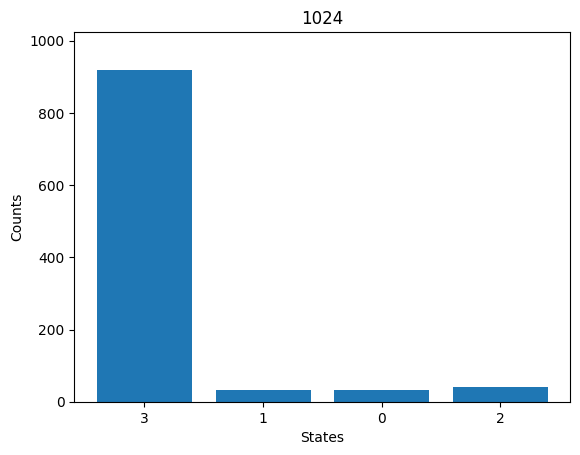

In [30]:
q = cirq.LineQid(0,dimension=4)
circ = cirq.Circuit(ModAdd(3,4).on(q),QuditDepolarizingChannel(0.12,4)(q))
circ.append(cirq.measure(q,key='Output'))
print(circ)
measured_noisy_circ = cirq.Simulator().run(circ,repetitions=1024)
result_noisy_circ = get_counts(measured_noisy_circ,key='Output')
print(result_noisy_circ)
plot_histogram(result_noisy_circ)

In [40]:
qudits2 = cirq.LineQid.range(4,dimension=4)
c_moment = cirq.Moment(Christensen(4).on(qudits2[1]))
# left_check = cirq.Moment()
# right_check = cirq.Moment(cirq.Moment(CZGate(1,1,4).on(qudits1[0]),CZGate(2,2,4).on(qudits1[0]),CZGate(3,3,4).on(qudits1[0])))
moment = (cirq.Moment(ModAdd(3,4).on(qudits2[0]))
                    )
circuit_pcs = cirq.Circuit(
    c_moment, 
    # Christensen(4).on(qudits2[2]),
    # CZGate(1,3,4).on(qudits2[2],qudits2[0]),CZGate(2,2,4).on(qudits2[2],qudits2[0]),CZGate(3,1,4).on(qudits2[2],qudits2[0]), moment,
    CModAdd(1,3,4).on(qudits2[1],qudits2[0]),CModAdd(2,2,4).on(qudits2[1],qudits2[0]),CModAdd(3,1,4).on(qudits2[1],qudits2[0]),moment,
    #   ZGate(2,4).on(qudits2[0]),
    CModAdd(1,1,4).on(qudits2[1],qudits2[0]),CModAdd(2,2,4).on(qudits2[1],qudits2[0]),CModAdd(3,3,4).on(qudits2[1],qudits2[0]), 
    # CZGate(1,3,4).on(qudits2[2],qudits2[0]),CZGate(2,2,4).on(qudits2[2],qudits2[0]),CZGate(3,1,4).on(qudits2[2],qudits2[0]), Christensen(4).on(qudits2[2]),
    c_moment, cirq.measure([*qudits2[:-2]],key='k')
)
print(circuit_pcs)

meas_pcs_sim = cirq.Simulator().run(circuit_pcs,repetitions=10)
ideal_pcs_res = get_counts(meas_pcs_sim,key='k')


0 (d=4): ────────[+++]───[++]───[+]───[+++]───[+]───[++]───[+++]────────M('k')───
                 │       │      │             │     │      │            │
1 (d=4): ───Cr───(1)─────(2)────(3)───────────(1)───(2)────(3)─────Cr───M────────


In [41]:
print(meas_pcs_sim)

k=3333333333, 0000000000


In [42]:
qudits2 = cirq.LineQid.range(4,dimension=4)
c_moment = cirq.Moment(Christensen(4).on(qudits2[1]))
# left_check = cirq.Moment()
# right_check = cirq.Moment(cirq.Moment(CZGate(1,1,4).on(qudits1[0]),CZGate(2,2,4).on(qudits1[0]),CZGate(3,3,4).on(qudits1[0])))
error_moment = (cirq.Moment(ModAdd(3,4).on(qudits2[0])),
                QuditDepolarizingChannel(0.12,4)(qudits2[0])
                    )
circuit_c = cirq.Circuit(
    c_moment, 
    # Christensen(4).on(qudits2[2]),
    # CZGate(1,3,4).on(qudits2[2],qudits2[0]),CZGate(2,2,4).on(qudits2[2],qudits2[0]),CZGate(3,1,4).on(qudits2[2],qudits2[0]),
    CModAdd(1,3,4).on(qudits2[1],qudits2[0]),CModAdd(2,2,4).on(qudits2[1],qudits2[0]),CModAdd(3,1,4).on(qudits2[1],qudits2[0]), error_moment,
    #   ZGate(2,4).on(qudits2[0]),
    CModAdd(1,1,4).on(qudits2[1],qudits2[0]),CModAdd(2,2,4).on(qudits2[1],qudits2[0]),CModAdd(3,3,4).on(qudits2[1],qudits2[0]), 
    # CZGate(1,3,4).on(qudits2[2],qudits2[0]),CZGate(2,2,4).on(qudits2[2],qudits2[0]),CZGate(3,1,4).on(qudits2[2],qudits2[0]), Christensen(4).on(qudits2[2]),
    c_moment, cirq.measure([*qudits2[:-2]],key='a')
)
print(circuit_c)

0 (d=4): ────────[+++]───[++]───[+]───[+++]───D4(0.12)───[+]───[++]───[+++]────────M('a')───
                 │       │      │                        │     │      │            │
1 (d=4): ───Cr───(1)─────(2)────(3)──────────────────────(1)───(2)────(3)─────Cr───M────────


{'20': 12, '30': 885, '12': 9, '22': 8, '33': 6, '11': 9, '10': 7, '31': 18, '23': 14, '03': 10, '13': 3, '32': 6, '02': 11, '00': 13, '21': 8, '01': 5}


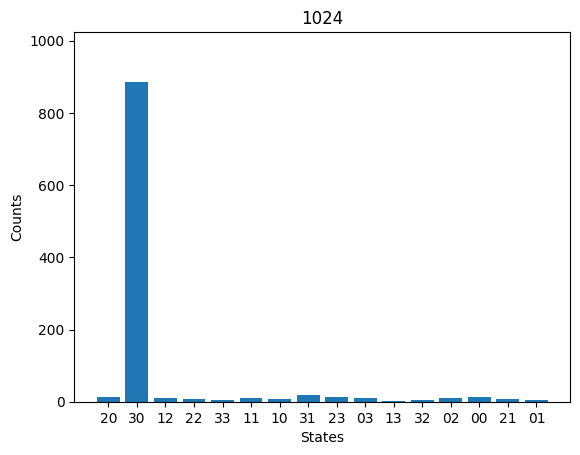

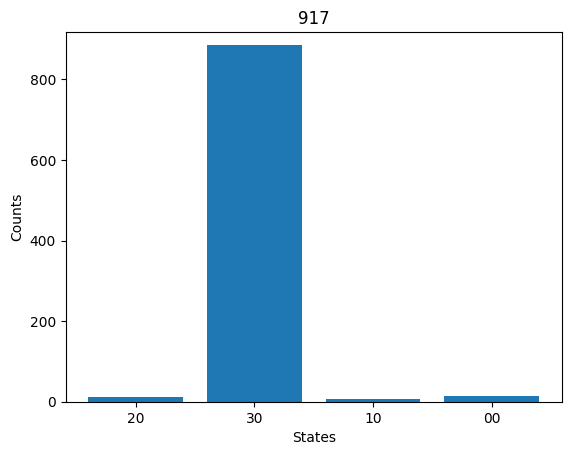

In [45]:

sim = cirq.Simulator()
samples = sim.run(circuit_c,repetitions=1024)
counts = get_counts(samples,key='a')
print(counts)
plot_histogram(counts)

#Performing post-selection based on syndrome outcomes
from qudit_ops.pcs import postselection
post_selected_counts = postselection(counts,ancillas=1)
plot_histogram(post_selected_counts)

In [46]:
qid = cirq.LineQid(0,dimension=4)
ideal_circuit = cirq.Circuit(ModAdd(3,4).on(qid),cirq.measure(qid,key='Output'))
print(ideal_circuit)
meas_sim = cirq.Simulator().run(ideal_circuit,repetitions=1024)
ideal_res = get_counts(meas_sim,key='Output')

#noisy fidelity
unmitigated_fid = hellinger_fidelity(ideal_res,result_noisy_circ)
mitigated_fid = hellinger_fidelity(ideal_pcs_res,post_selected_counts)
print("Unmitigated Fidelity:", unmitigated_fid)
print("Mitigated Fidelity:", mitigated_fid)

0 (d=4): ───[+++]───M('Output')───
Unmitigated Fidelity: 0.8984375
Mitigated Fidelity: 0.965103598691385


In [47]:
def ghz(dims: int,n_qudits: int = 2) -> cirq.Circuit:
    total_qids = n_qudits + 2
    qids = cirq.LineQid.range(total_qids, dimension=dims)

    z_rcheck = lambda : [circuit.append(CZGate(i,dims-i,dims).on(qids[2],qids[0])) for i in range(1,dims)]
    z_lcheck = lambda : [circuit.append(CZGate(i,i,dims).on(qids[2],qids[0])) for i in range(1,dims)]
    x_lcheck = lambda : [circuit.append(CModAdd(i,dims-i,dims).on(qids[3],qids[1])) for i in range(1,dims)]
    x_rcheck = lambda : [circuit.append(CModAdd(i,i,dims).on(qids[3],qids[1])) for i in range(1,dims)]
    error_moment = cirq.Moment(QuditDepolarizingChannel(0.12,dims).on_each(qids[0],qids[1]))
    circuit = cirq.Circuit()
    circuit.append(Christensen(dim=dims).on_each(qids[0],qids[2]))
    z_lcheck()
    circuit.append(Christensen(dim=dims).on(qids[3]))
    x_lcheck()
    circuit.append(error_moment)
    for k in range(dims-1):
        circuit.append(CModAdd(k+1,k+1,dims).on(qids[0],qids[1]))
    x_rcheck()
    z_rcheck()
    circuit.append(Christensen(dim=dims).on(qids[3]))
    circuit.append(Christensen(dim=dims).on(qids[2]))
    
    circuit.append(cirq.measure(*qids,key='a'))
    return circuit
pcs_noisy_ghz = ghz(2,2)
print(pcs_noisy_ghz)
    

                 ┌──────┐                    ┌──────┐
0 (d=2): ───Cr────Z─────────D2(0.12)───(1)───────Z───────────M('a')───
                  │                    │         │           │
1 (d=2): ─────────┼──[+]────D2(0.12)───[+]────[+]┼───────────M────────
                  │  │                        │  │           │
2 (d=2): ───Cr────(1)┼────────────────────────┼──(1)────Cr───M────────
                     │                        │              │
3 (d=2): ───Cr───────(1)──────────────────────(1)───────Cr───M────────
                 └──────┘                    └──────┘


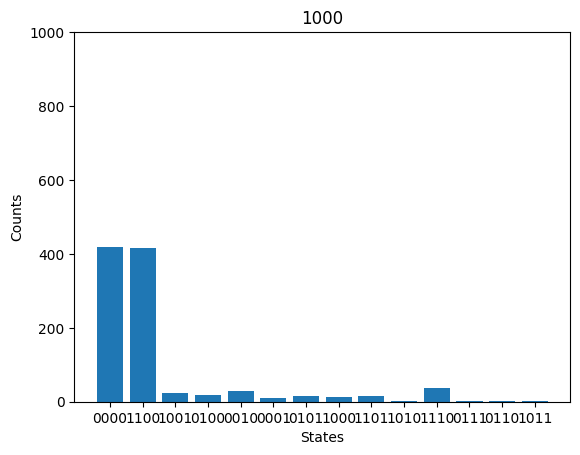

In [48]:
sim = cirq.Simulator()
result = sim.run(pcs_noisy_ghz,repetitions=1000)
pcs_noisy_ghz_counts = get_counts(result,key='a')
plot_histogram(pcs_noisy_ghz_counts)

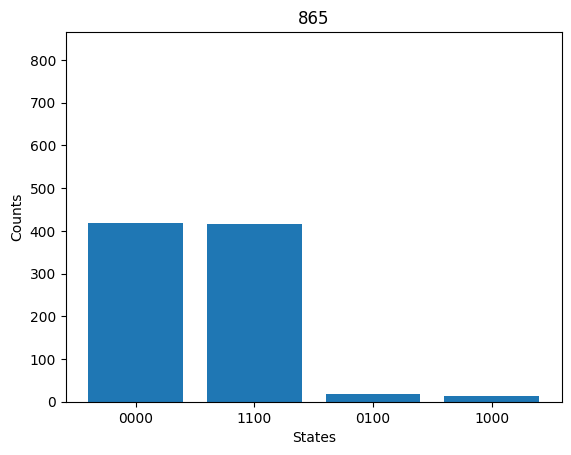

In [49]:
post_selected_pcs = postselection(pcs_noisy_ghz_counts,ancillas=2)
plot_histogram(post_selected_pcs)

In [50]:
def ideal_ghz(dims: int,n_qudits: int = 2) -> cirq.Circuit:
    qids = cirq.LineQid.range(n_qudits, dimension=dims)
    circuit = cirq.Circuit()
    circuit.append(Christensen(dim=dims).on(qids[0]))
    for k in range(dims- 1):
        circuit.append(CModAdd(k+1,k+1,dims).on(qids[0],qids[1]))
    circuit.append(cirq.measure(*qids,key='a'))
    return circuit
ideal_ghz = ideal_ghz(2)


In [51]:
def noisy_ghz(dims: int,n_qudits: int = 2) -> cirq.Circuit:
    qids = cirq.LineQid.range(n_qudits, dimension=dims)
    circuit = cirq.Circuit()
    circuit.append(Christensen(dim=dims).on(qids[0]))
    
    for k in range(dims- 1):
        circuit.append(CModAdd(k+1,k+1,dims).on(qids[0],qids[1]))
    circuit.append(cirq.Moment(QuditDepolarizingChannel(0.12,dims).on_each(qids[0],qids[1])))
    circuit.append(cirq.measure(*qids,key='a'))
    return circuit
noisy_ghz = noisy_ghz(2)
print(noisy_ghz)

0 (d=2): ───Cr───(1)───D2(0.12)───M('a')───
                 │                │
1 (d=2): ────────[+]───D2(0.12)───M────────


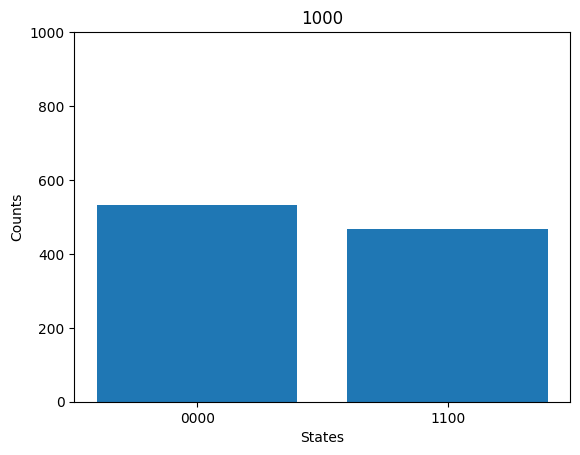

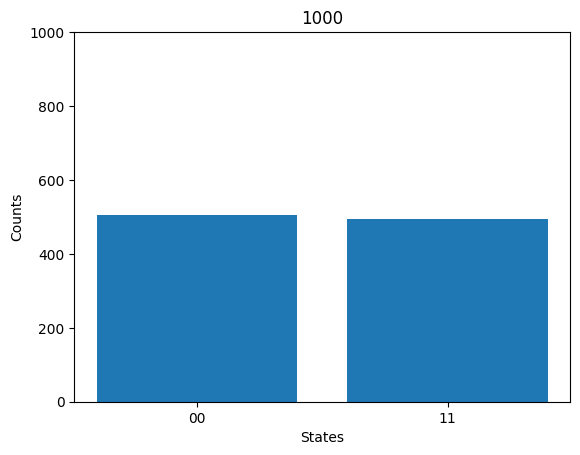

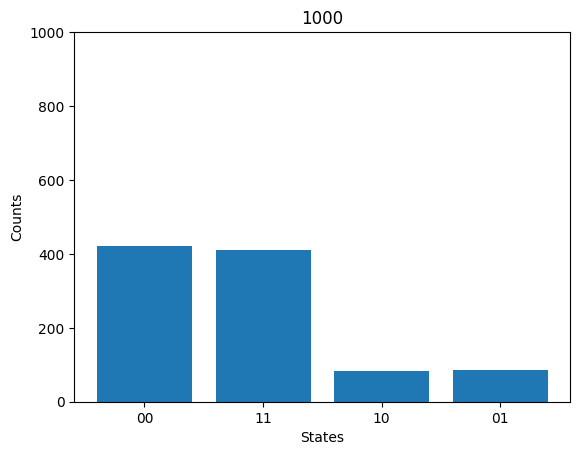

In [52]:
sim = cirq.Simulator()
pcs_ideal_ghz_result = sim.run(pcs_ideal_ghz,repetitions=1000)
pcs_ideal_ghz_counts = get_counts(pcs_ideal_ghz_result,key='a')
plot_histogram(pcs_ideal_ghz_counts)


ideal_ghz_result = sim.run(ideal_ghz,repetitions=1000)
ideal_ghz_counts = get_counts(ideal_ghz_result,key='a')
plot_histogram(ideal_ghz_counts)

noisy_ghz_result = sim.run(noisy_ghz,repetitions=1000)
noisy_ghz_counts = get_counts(noisy_ghz_result,key='a')
plot_histogram(noisy_ghz_counts)

In [53]:
#noisy fidelity
unmitigated_fid = hellinger_fidelity(ideal_ghz_counts,noisy_ghz_counts)
mitigated_fid = hellinger_fidelity(pcs_ideal_ghz_counts,post_selected_pcs)
print("Unmitigated Fidelity:", unmitigated_fid)
print("Mitigated Fidelity:", mitigated_fid)

Unmitigated Fidelity: 0.8319987785560338
Mitigated Fidelity: 0.9632461400088832


In [ ]:
c = cirq.Circuit()
qid = cirq.LineQid.range(2, dimension=5)
c.append(CModAdd())